In [1]:
# 分析和整理
import numpy as np
import pandas as pd
import random as rnd

# 可视化
import seaborn as sns
import matplotlib.pyplot as plt

# 模型
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier



train_df = pd.read_csv("/Users/liuwentao/Desktop/titanic/train.csv")
test_df = pd.read_csv("/Users/liuwentao/Desktop/titanic/test.csv")
combine = [train_df, test_df] # 将两个数据集并在一起，对两个数据集进行某些操作

print(train_df.columns.values)
print(train_df.head())


['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3


可以把特征分为几种：  
- categorical绝对的：比如这里的survived,embarked
- ordinal序数词：这里的Pclass
- continous连续性的：这里的age, fare
- discrete分离的：slibsp,parch

看一下哪些特征是存在多种数据类型的：比如这里的ticket，既有字母又有数字，对于这种就需要我们去correct。

看一下哪些特征的数据可能存在错误，比如这里name特征，因为有些人name当中是加了title的

看一下包含blank，null，empty value的，看一下特征的数据类型。

In [2]:
train_df.info()
print('-'*40)
test_df.info()

# 看一下样本中数值型特征的分布情况怎么样的，通过这个我们可以有一个预期的判断，可以看到它代表了实际问题域
print('-'*40)
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


基于数据分析的假设

correlation：看看每个特征和survival的关联性怎么样。  

completing: 还需要去补全age特征，因为它和survival之间关联，embarked特征也要补全。  

correcting：可能我们会drop掉一些与survival无关的特征，可能因为这个特征根本没啥关系、或者这个特征缺少的值太多，加入这个特征反而会带来noise  

creating：根据已有特征创造一些新的特征，比如这里基于parch和slibsp创造一个family特征，获取家庭成员总数量。  

classifying：分类，根据问题称述可以做出一些假设，比如女人和小孩和Pclass为1的survival更高



In [3]:
# train_df = pd.read_csv("/Users/liuwentao/Desktop/titanic/train.csv")
# test_df = pd.read_csv("/Users/liuwentao/Desktop/titanic/test.csv")
# combine = [train_df, test_df] # 将两个数据集并在一起，对两个数据集进行某些操作
# 通过对某一个特征点来分析，如果觉得女人和小孩或者pclass为1的乘客survival更高，我们可以对他们单个进行分析
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [4]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [5]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [6]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000



## 可以发现SibSp和Parch对survival的值没有相关性

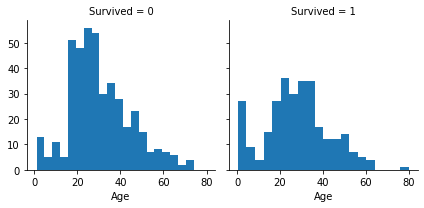

In [7]:
# 看看数值型特征和survival之间的关联，可以用histogram矩形图来观察
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)



从上图可以发现：
- 四岁以下的survival比较高
- 存活了的乘客当中年纪最大的有80岁
- 活下来的当中15-25岁的比较少
- 大部分乘客是15-35岁之间

所以进一步验证了我的之前的假设：年龄和survival有很大关系，所以我们应该去补全那些年龄为null的地方，还应该划分年龄段

/Users/liuwentao/Code/PycharmProjects/titanic/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


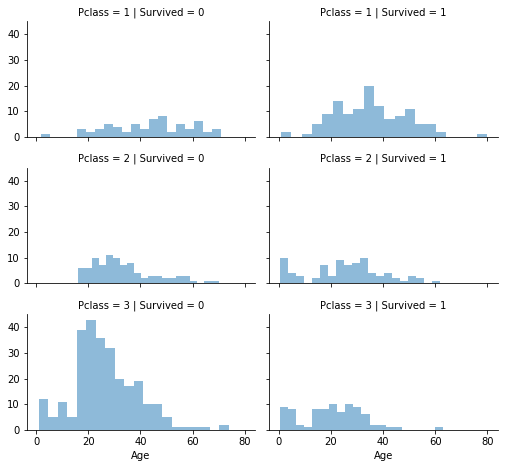

In [8]:
# 将数值和序数词特征相关联，比如这里的Pclass有1，2，3，但是1，2，3只表示一种序数词，它并没有一种数值上的关系，所以要想办法将Pclass的1，2，3转成数值上的某种关系
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();


- 可以发现Pclass为3的乘客最多，但是大多数没有存活。证明了我们的分类假设。
- 而且Pclass为2和3中的婴儿乘客大部分存活了，这又进一步证明了我们的假设，就是survival与年龄有关，而且和Pclass有关
- Pclass为1的大部分乘客存活了，证明了我们的假设3.
- 还可以看到Pcalss为1的乘客大部分在30-50岁之间。
### 所以应该把Pclass考虑到model中



## 接来下看看Correlating categorical features

/Users/liuwentao/Code/PycharmProjects/titanic/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/liuwentao/Code/PycharmProjects/titanic/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/liuwentao/Code/PycharmProjects/titanic/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:650: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


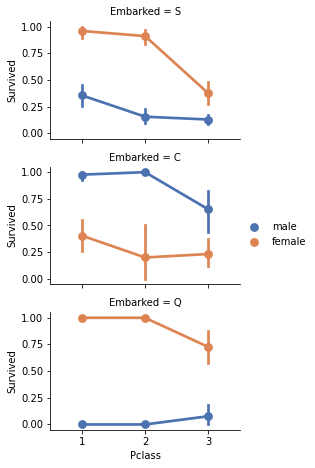

In [9]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()


可以看到女性比男性存活率更高，验证了分类1.
embarked=C这里男性存活更高，这里应该是Pclass和embarked之间的关联，从而转化成Pclass和survived之间关联，其实embarked和survived没有直接关联

### 所以决定考虑性别特征、填充并且添加embarked特征到模型中


/Users/liuwentao/Code/PycharmProjects/titanic/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/liuwentao/Code/PycharmProjects/titanic/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


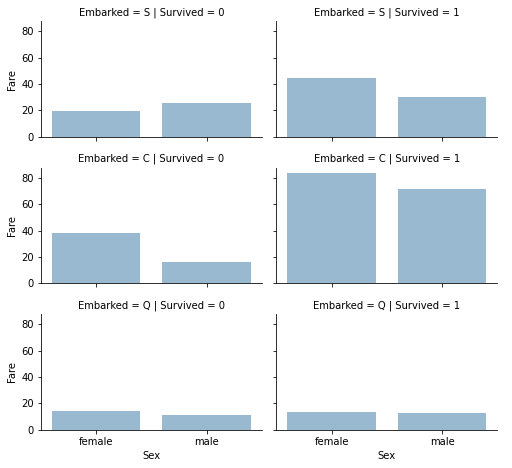

In [10]:
# 我们还可能需要将分类特征（也就是非数字特征）和数字特征相关联，可以考虑将embarked（分类非数字）、性别（分类非数字）、票价（数字连续）与survived（分类数字）相关联

grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()


可以看到票价越高，survived越高，而且embarkation的上船岸口和survived也有关，所以应该将fare这个特征考虑到model中


# 以上都是分析数据，做出一些假设，验证假设。到目前为止还没有改变任何一个特征的值，下面开始wrangle data整理数据，Let us now execute our decisions and assumptions for correcting, creating, and completing goals.

## correcting by drop features
通过丢弃一些特征，这样我们可以处理更少的数据，简化分析。但是不能随便丢弃，我们基于assumption and decisions决定丢弃cabin(correcting #2) and Ticket (correcting #1)
然后下面开始执行数据操作。

In [11]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

'After', train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))


## Creating new feature extracting from existing
我们想看看能不能对name特征加工一下去提取出titles，然后看看titles和survived之间有没有关系，最后就可以drop掉name和passengerID特征了。  
用正则表达式去提取title特征。

In [12]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40



### 可以观察到以下：
When we plot Title, Age, and Survived, we note the following observations.

- Most titles band Age groups accurately. For example: Master title has Age mean of 5 years.
- Survival among Title Age bands varies slightly.
- Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer).

Decision.

所以考虑把新创建的title特征放到model中去训练


由于上面title的种类太多了，我们就把他们换成更加普遍的名字、rare。

In [13]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826



### 再把这些title转换成序数词

In [14]:
title_mapping = {"Mr" : 1, "Miss" : 2, "Mrs" : 3, "Master" : 4, "Rare" : 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1



### 然后现在就可以drop掉name和passengerId这两个特征了，注意要在train_df和test_df中都需要drop

In [15]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

## Converting a categorical feature
现在我们将包含字符串的特征转换成数值型特征，全都转成数值型之后也会帮我们实现填充特征的goal。接下来通过female=1and male=0将原来的gender特征转成数值型sex特征。

In [16]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female' : 1, 'male' : 0}).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


## Completing a numerical continuous feature
### 接下来开始补全缺失值，先对age进行补全。
有三种补全方式：
- 一种简单的方法是在均值和标准差之间生成随机数
- 还可以通过利用其它特征来猜测缺失值， In our case we note correlation among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...
- 结合方法1和方法2。因此，不要根据中位数来猜测年龄值，而是使用平均值和标准差之间的随机数，基于一组Pclass和性别组合

第一种和第三种方法will introduce random noise into our models，所以这里采用方法二。

/Users/liuwentao/Code/PycharmProjects/titanic/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


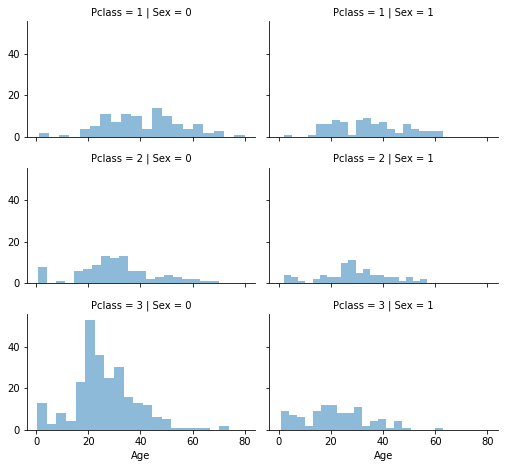

In [17]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()


### 开始准备一个空数组来存储我们基于Pclass x Sex的联合来猜测的年龄

In [18]:
guess_ages = np.zeros((2, 3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])


### Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations
利用方法二去猜测这些空的age值应该是多少

In [19]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j + 1)]['Age'].dropna()
            
            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)
            
            age_guess = guess_df.median()
            
            # Convert random age float to nearest .5 age
            guess_ages[i, j] = int(age_guess/ 0.5 + 0.5) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j + 1), 'Age'] = guess_ages[i, j]
    
    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1



### 又通过给年龄划分成一个个的区间，来观察各年龄段和survived之间的关系

In [20]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


### 将AgeBand换成序数型特征

In [21]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

train_df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"



### 现在就可以drop掉ageband了

In [22]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1



## Create new feature combining existing features
我们还可以通过将Parch和SlibSp联合起来创建一个新的特征FamilySize,这样就可以drop掉Parch和SlibSp

In [23]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)



,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000



### 我们还可以创建一个IsAlone特征

In [24]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()



,IsAlone,Survived
0,0,0.505650
1,1,0.303538



### 在FamilySize那里的表格可以看到其实它和survived没有一个线性关系，所以我们创建了一个IsAlone特征，这个特征就和survived有线性关系了，所以把其它几个特征直接drop掉


In [25]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1



### 我们还可以通过联系Pclass和Age创造一个新的特征Age*Class

In [26]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2



### 补全这里的分类特征
Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [27]:
# 找出现频率最高的登船口，然后就简单拿这个去补全那几个空值
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port


'S'

In [28]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009



从上面这个结果可以看到embarked是与survived有关系的，我们可以将其转成数值型特征，让它和survived成线性关系。

## 'S': 0, 'C': 1, 'Q': 2好像有问题！！！？？等会再看

In [29]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()


,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6



## 到目前为止还有Fare特征没有处理，所以在这里我们简单用中位数来补全一下，然后把它转换成序数型特征（其实就是将其划分成区间段，给每个区间段标记为一个序数，这样避免了某些不太正常的样本对模型产生噪音）
请注意，我们并没有创建中间的新特性，也没有对相关性进行任何进一步的分析，以猜测缺失的特性，因为我们只替换了一个值。完成目标达到了模型算法对非空值进行运算的预期要求

In [30]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3



## 然后就是创造FareBand了

In [31]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081



## 可以看到FareBand和Survived呈线性关系

In [32]:

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [33]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3



# 以上处理数据部分全部结束，接下来开始model,predict and solve
开始用处理好的数据训练模型，开始预测，我们的问题是一个classification and regression问题，我们想搞清输入的特征和输出的survived之间的联系，同时这也是一个监督学习，因为我们的train_df中有输入，也有对应的输出。
### 监督学习+分类+回归问题，可以用以下模型：
- Logistic Regression
- KNN or k-Nearest Neighbors
- Support Vector Machines
- Naive Bayes classifier
- Decision Tree
- Random Forrest
- Perceptron
- Artificial neural network
- RVM or Relevance Vector Machine

In [34]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

## Logistic Regression
最开始逻辑回归比较有用，它可以看到自变量（特征）和因变量之间的系数关系。

In [45]:
# logreg = LogisticRegression()
# logreg.fit(X_train, Y_train)
# Y_pred = logreg.predict(X_test)
# acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
# acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
# acc_log



我们通过逻辑回归函数中的系数去验证我们之前的assumption和decision，



In [36]:
# coeff_df = pd.DataFrame(train_df.columns.delete(0))
# coeff_df.columns = ['Feature']
# coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

# coeff_df.sort_values(by='Correlation', ascending=False)


 ## 接下来用SVM
 这也是监督学习模型，给定一组训练样本，每一个样本都属于两个类别中的一个或另一个，支持向量机训练演算法会建立一个模型，将新的测试样本指派给一个类别或另一个类别，使之成为非概率二元线性分类器

In [46]:
# svc = SVC()
# svc.fit(X_train, Y_train)
# Y_pred = svc.predict(X_test)
# acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
# acc_svc


## k-NN
在模式识别当中，k-NN算法是一种使用分类和回归的非参数方法，也就是说它不像线性回归那样有一个公式，每个特征都有一个系数，一个样本是由其邻居的多数票进行分类的，样本被分配到k个最近邻中最常见的类（k是一个正整数，通常很小）。如果k=1，则只需将该对象指定给该单个最近邻的类。

In [38]:
# knn = KNeighborsClassifier(n_neighbors = 3)
# knn.fit(X_train, Y_train)
# Y_pred = knn.predict(X_test)
# acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
# acc_knn

In [39]:
## 贝叶斯分类器
# gaussian = GaussianNB()
# gaussian.fit(X_train, Y_train)
# Y_pred = gaussian.predict(X_test)
# acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
# acc_gaussian

## perceptron
这是一种二分类监督学习算法

In [40]:
# perceptron = Perceptron()
# perceptron.fit(X_train, Y_train)
# Y_pred = perceptron.predict(X_test)
# acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
# acc_perceptron

In [41]:
# Linear SVC

# linear_svc = LinearSVC()
# linear_svc.fit(X_train, Y_train)
# Y_pred = linear_svc.predict(X_test)
# acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
# acc_linear_svc

In [42]:
# Stochastic Gradient Descent

# sgd = SGDClassifier()
# sgd.fit(X_train, Y_train)
# Y_pred = sgd.predict(X_test)
# acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
# acc_sgd

In [43]:
# Decision Tree

# decision_tree = DecisionTreeClassifier()
# decision_tree.fit(X_train, Y_train)
# Y_pred = decision_tree.predict(X_test)
# acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
# acc_decision_tree



In [44]:
# Random Forest

# random_forest = RandomForestClassifier(n_estimators=100)
# random_forest.fit(X_train, Y_train)
# Y_pred = random_forest.predict(X_test)
# random_forest.score(X_train, Y_train)
# acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
# acc_random_forest
